In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import glob
import tensorflow as tf

In [ ]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, '/content/drive/MyDrive/Data')

img_path =  os.path.join(data_dir,'slip_img.npz')
f = np.load(img_path)

slip_grd_all = f['slip_grd_all']
print(slip_grd_all.shape)

(1800, 61, 38)


In [ ]:
#load data run-up, inundation area
inund_path = os.path.join(data_dir, 'max_inundation.npz')
f = np.load(inund_path)

inund_px_all = f['inund_px_all']
print(inund_px_all.shape)
runup_all = f['runup_all']
print(runup_all.shape)

#load output hmax

#Viña del mar

viña_path = os.path.join(data_dir, 'vina_inland_gauge.npz')
f_viña = np.load(viña_path)
h_viña = f_viña['h']
#Valparaíso

valpo_path = os.path.join(data_dir, 'valpo_inland_gauge.npz')
f_valpo = np.load(valpo_path)
h_valpo = f_valpo['h']
#Cartagena

cartagena_path = os.path.join(data_dir, 'cartagena_inland_gauge.npz')
f_cartagena = np.load(cartagena_path)
h_cartagena = f_cartagena['h']
#San Antonio

sanantonio_path = os.path.join(data_dir, 'santonio_inland_gauge.npz')
f_santonio = np.load(sanantonio_path)
h_santonio = f_santonio['h']

#hmax para cada estación
hmax_viña = np.max(h_viña, axis = 1)
#print(hmax_viña.shape)
hmax_valpo = np.max(h_valpo, axis = 1)
#print(hmax_valpo.shape)
hmax_cartagena = np.max(h_cartagena, axis = 1)
#print(hmax_cartagena.shape)
hmax_santonio = np.max(h_santonio, axis = 1)
#print(hmax_santonio.shape)

#Vector 4x1 hV²max

h_max = np.stack((hmax_viña, hmax_valpo, hmax_cartagena, hmax_santonio), axis=-1)
print(h_max.shape)

(4, 1800)
(4, 1800)
(1800, 4)


In [ ]:
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
# Load uplift sources
dz_path = os.path.join(data_dir, 'uplift.npz')
f = np.load(dz_path)

dz_all = f['dz_all'].astype(np.float32)
extent_uplift = f['extent_uplift']
print(dz_all.shape)

(1800, 150, 132)


In [ ]:
X = dz_all
Y1 = runup_all.T # 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y2 = inund_px_all.T/68771

In [ ]:
Y3 = h_max

In [ ]:
Y = np.hstack((Y1,Y2,Y3))
Y.shape

(1800, 12)

In [ ]:
#split data 80 and 20%
X_train, X_test = train_test_split(X, train_size=0.8, shuffle=True, random_state=1) # this split the slip data
Y_train, Y_test = train_test_split(Y, train_size=0.8, shuffle=True, random_state=1) # this split the run-up, inundation area and hmax data

In [ ]:
print(np.shape(X_train)) # should be (1440, 150, 132)
print(np.shape(Y_train)) # should be (1440, 12)

(1440, 150, 132)
(1440, 12)


In [ ]:
train_images = X_train
train_labels = Y_train
test_images = X_test
test_labels = Y_test

In [ ]:
max(train_images.max(), test_images.max())


10.296875

In [ ]:
max(train_labels.max(), test_labels.max())

40.15982437133789

In [ ]:
# Normalize the images.
train_images = (train_images / 10.296875)
test_images = (test_images / 10.296875)


In [ ]:
# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (1440, 150, 132, 1)
print(test_images.shape)  # (360, 150, 132, 1)

(1440, 150, 132, 1)
(360, 150, 132, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, regularizers

L2 = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='linear', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(12))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam' , metrics=['mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 149, 131, 16)      80        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 65, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 73, 64, 32)        2080      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 35, 31, 32)        4128      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 15, 32)       

In [ ]:
history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,
                    validation_data=(test_images, test_labels))

Epoch 1/200
45/45 [==============================] - 3s 14ms/step - loss: 17.0015 - mean_squared_error: 16.9662 - val_loss: 6.0034 - val_mean_squared_error: 5.9729
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 4.9295 - mean_squared_error: 4.9002 - val_loss: 3.6626 - val_mean_squared_error: 3.6340
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2.7272 - mean_squared_error: 2.6990 - val_loss: 2.1291 - val_mean_squared_error: 2.1015
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 1.8275 - mean_squared_error: 1.8000 - val_loss: 1.7770 - val_mean_squared_error: 1.7496
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 1.4288 - mean_squared_error: 1.4014 - val_loss: 1.3376 - val_mean_squared_error: 1.3101
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 1.1127 - mean_squared_error: 1.0848 - val_loss: 1.0513 - val_mean_squared_error: 1.0230
Epoch 7/200
45/45 [============

In [ ]:
#Save variables in .npy
predictions = model.predict(test_images)
train_predictions = model.predict(train_images)
np.save('../content/drive/MyDrive/Data/predictions_uplift_data1_12.npy',predictions)
np.save('../content/drive/MyDrive/Data/train_predictions_uplift_data1_12.npy',train_predictions)

45/45 [==============================] - 0s 3ms/step


In [ ]:
h = history.history['mean_squared_error']
np.save('../content/drive/MyDrive/Data/history_uplift_data1_12.npy',h)

In [ ]:
h_val = history.history['val_mean_squared_error']
np.save('../content/drive/MyDrive/Data/history_val_uplift_data1_12.npy',h_val)

In [ ]:
#Load variables
predictions=np.load('../content/drive/MyDrive/Data/predictions_uplift_data1_12.npy')
train_predictions = np.load('../content/drive/MyDrive/Data/train_predictions_uplift_data1_12.npy')
h= np.load('../content/drive/MyDrive/Data/history_uplift_data1_12.npy')
h_val = np.load('../content/drive/MyDrive/Data/history_val_uplift_data1_12.npy')

(1440, 12)
(360, 12)
MSE test: 0.27711697576609257
MSE train: 0.05193966112841679


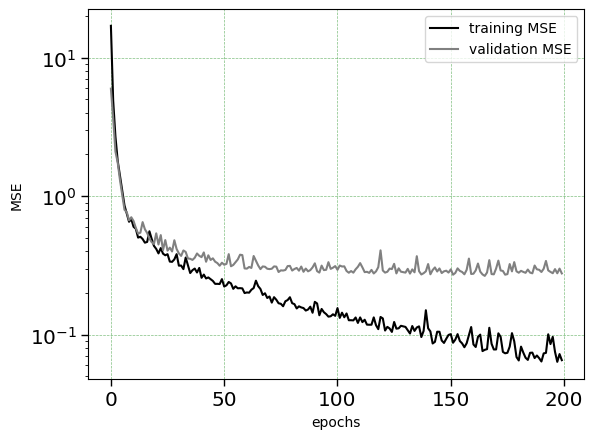

In [ ]:
#Graphics of performance
plt.plot(h, label = 'training MSE', color="k")
plt.plot(h_val, label = 'validation MSE', color="gray")
plt.tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='g', grid_alpha=0.5, labelsize='x-large')
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('epochs')

y_star_train = train_predictions
y_star_test = predictions
print(np.shape(y_star_train))
print(np.shape(y_star_test))

MSE_test = np.average((y_star_test - test_labels)**2)
MSE_train = np.average((y_star_train - train_labels )**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)

In [ ]:
#R2 graphics for 45° line (1:1)
from sklearn.metrics import r2_score
y_true = test_labels[:,0]
y_pred= predictions[:,0]
r2_run1 = r2_score(y_true, y_pred)

y_true = test_labels[:,1]
y_pred= predictions[:,1]
r2_run2 = r2_score(y_true, y_pred)

y_true = test_labels[:,2]
y_pred= predictions[:,2]
r2_run3 = r2_score(y_true, y_pred)

y_true = test_labels[:,3]
y_pred= predictions[:,3]
r2_run4 = r2_score(y_true, y_pred)

y_true = test_labels[:,4]
y_pred= predictions[:,4]
r2_ia1 = r2_score(y_true, y_pred)

y_true = test_labels[:,5]
y_pred= predictions[:,5]
r2_ia2 = r2_score(y_true, y_pred)

y_true = test_labels[:,6]
y_pred= predictions[:,6]
r2_ia3 = r2_score(y_true, y_pred)

y_true = test_labels[:,7]
y_pred= predictions[:,7]
r2_ia4 = r2_score(y_true, y_pred)

y_true = test_labels[:,8]
y_pred= predictions[:,8]
r2_hmax1 = r2_score(y_true, y_pred)

y_true = test_labels[:,9]
y_pred= predictions[:,9]
r2_hmax2 = r2_score(y_true, y_pred)

y_true = test_labels[:,10]
y_pred= predictions[:,10]
r2_hmax3 = r2_score(y_true, y_pred)

y_true = test_labels[:,11]
y_pred= predictions[:,11]
r2_hmax4 = r2_score(y_true, y_pred)

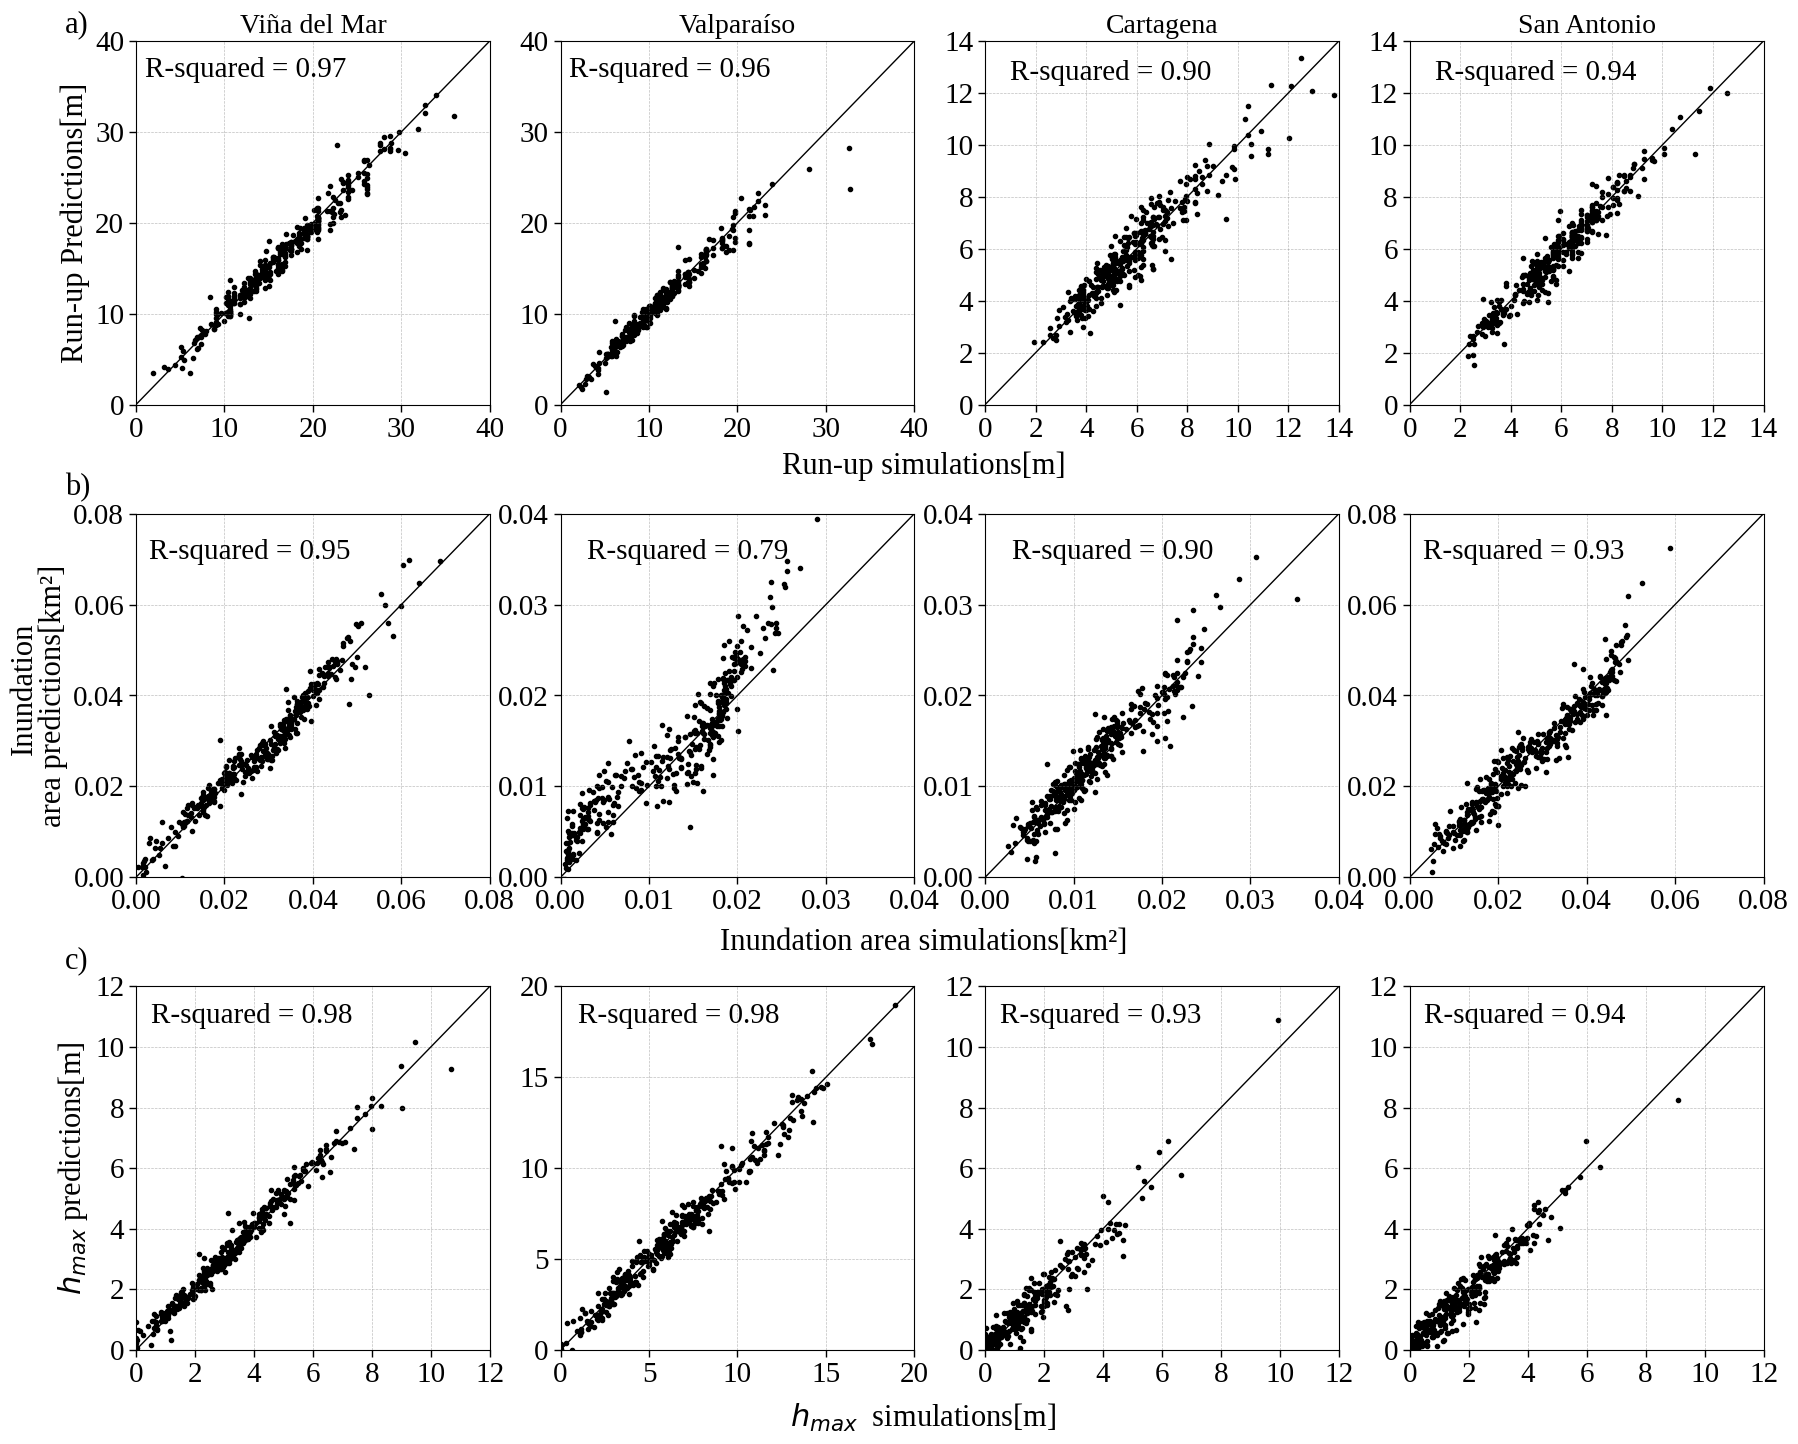

In [ ]:
#Plots

from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

#Font Liberation Serif
font_path = fm.findSystemFonts(fontpaths=None, fontext='ttf')
liberation_serif_fonts = [font for font in font_path if 'liberationserif' in font.lower()]
liberation_serif_font = liberation_serif_fonts[0] if liberation_serif_fonts else None

if liberation_serif_font:
    plt.rcParams['font.family'] = "Liberation Serif"


f, ax = plt.subplots(3, 4, figsize=(21, 17), gridspec_kw={'hspace': 0.3})
#Run-up
#Viña del Mar
ax[0,0].scatter(test_labels[:,0], predictions[:,0], color = 'k', marker = '.')
ax[0,0].set_title("Viña del Mar",fontsize = 20)
ax[0,0].set_ylabel('Run-up Predictions[m]',fontsize = 22 )
ax[0,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,0].tick_params(axis="x", labelsize=21)
ax[0,0].tick_params(axis="y", labelsize=21)
ax[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,0].set_xlim([0, 40])
ax[0,0].set_ylim([0, 40])
ax[0,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run1)
ax[0,0].text(1, 36, f'R-squared = {r2_run1:.2f}', fontsize=21, color='k')
ax[0,0].text(-8, 41, 'a)', fontsize = 22)
ax[0,0].text(-8, -10, 'b)', fontsize = 22)
ax[0,0].text(-8, -62, 'c)', fontsize = 22)

#Valparaíso
ax[0,1].scatter(test_labels[:,1], predictions[:,1], color = 'k', marker = '.')
ax[0,1].set_title("Valparaíso",fontsize = 20)
ax[0,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,1].tick_params(axis="x", labelsize=21)
ax[0,1].tick_params(axis="y", labelsize=21)
ax[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,1].set_xlim([0, 40])
ax[0,1].set_ylim([0, 40])
ax[0,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run2)
ax[0,1].text(1, 36, f'R-squared = {r2_run2:.2f}', fontsize=21, color='k')

#Cartagena
ax[0,2].scatter(test_labels[:,2], predictions[:,2], color = 'k', marker = '.')
ax[0,2].set_title("Cartagena", fontsize = 20)
ax[0,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,2].tick_params(axis="x", labelsize=21)
ax[0,2].tick_params(axis="y", labelsize=21)
ax[0,2].set_xlim([0, 14])
ax[0,2].set_ylim([0, 14])
ax[0,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run3)
ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].text(1, 12.5, f'R-squared = {r2_run3:.2f}', fontsize=21, color='k')

#San Antonio
ax[0,3].scatter(test_labels[:,3], predictions[:,3], color = 'k', marker = '.')
ax[0,3].set_title("San Antonio", fontsize = 20)
ax[0,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,3].tick_params(axis="x", labelsize=21)
ax[0,3].tick_params(axis="y", labelsize=21)
ax[0,3].set_xlim([0, 14])
ax[0,3].set_ylim([0, 14])
ax[0,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run4)
ax[0,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].text(1, 12.5, f'R-squared = {r2_run4:.2f}', fontsize=21, color='k')
f.text(0.5, 0.63, 'Run-up simulations[m]', ha='center', va='center', fontsize=22)

#Inundation area
#Viña del Mar
ax[1,0].scatter(test_labels[:,4]*68771*1e-6, predictions[:,4]*68771*1e-6, color = 'k', marker = '.')
f.text(0.065, 0.46, 'Inundation', ha='left', va='bottom', fontsize=22, rotation=90)
ax[1,0].set_ylabel('area predictions[km²]',fontsize = 22 )
ax[1,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,0].tick_params(axis="x", labelsize=21)
ax[1,0].tick_params(axis="y", labelsize=21)
ax[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,0].set_xlim([0, .08])
ax[1,0].set_ylim([0, .08])
ax[1,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia1)
ax[1,0].text(0.003, 0.07, f'R-squared = {r2_ia1:.2f}', fontsize=21, color='k')

#Valparaíso
ax[1,1].scatter(test_labels[:,5]*68771*1e-6, predictions[:,5]*68771*1e-6, color = 'k', marker = '.')
ax[1,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,1].tick_params(axis="x", labelsize=21)
ax[1,1].tick_params(axis="y", labelsize=21)
ax[1,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,1].set_xlim([0, .04])
ax[1,1].set_ylim([0, .04])
ax[1,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia2)
ax[1,1].text(0.003, 0.035, f'R-squared = {r2_ia2:.2f}', fontsize=21, color='k')

#Cartagena
ax[1,2].scatter(test_labels[:,6]*68771*1e-6, predictions[:,6]*68771*1e-6, color = 'k', marker = '.')
ax[1,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,2].tick_params(axis="x", labelsize=21)
ax[1,2].tick_params(axis="y", labelsize=21)
ax[1,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,2].set_xlim([0, .04])
ax[1,2].set_ylim([0, .04])
ax[1,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia3)
ax[1,2].text(0.003, 0.035, f'R-squared = {r2_ia3:.2f}', fontsize=21, color='k')

#San Antonio
ax[1,3].scatter(test_labels[:,7]*68771*1e-6, predictions[:,7]*68771*1e-6, color = 'k', marker = '.')
ax[1,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,3].tick_params(axis="x", labelsize=21)
ax[1,3].tick_params(axis="y", labelsize=21)
ax[1,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,3].set_xlim([0, .08])
ax[1,3].set_ylim([0, .08])
ax[1,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia4)
ax[1,3].text(0.003, 0.07, f'R-squared = {r2_ia4:.2f}', fontsize=21, color='k')

f.text(0.5, 0.35, 'Inundation area simulations[km²]', ha='center', va='center', fontsize=22)

#hmax
#Viña del Mar
ax[2,0].scatter(test_labels[:,8], predictions[:,8], color = 'k', marker = '.')
ax[2,0].set_ylabel('$h_{max}$ predictions[m]',fontsize = 22 )
ax[2,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,0].tick_params(axis="x", labelsize=21)
ax[2,0].tick_params(axis="y", labelsize=21)
ax[2,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,0].set_xlim([0, 12])
ax[2,0].set_ylim([0, 12])
ax[2,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax1)
ax[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,0].text(0.5, 10.8, f'R-squared = {r2_hmax1:.2f}', fontsize=21, color='k')

#Valparaíso
ax[2,1].scatter(test_labels[:,9], predictions[:,9], color = 'k', marker = '.')
ax[2,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,1].tick_params(axis="x", labelsize=21)
ax[2,1].tick_params(axis="y", labelsize=21)
ax[2,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,1].set_xlim([0, 20])
ax[2,1].set_ylim([0, 20])
ax[2,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax2)
ax[2,1].text(1, 18, f'R-squared = {r2_hmax2:.2f}', fontsize=21, color='k')

#Cartagena
ax[2,2].scatter(test_labels[:,10], predictions[:,10], color = 'k', marker = '.')
ax[2,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,2].tick_params(axis="x", labelsize=21)
ax[2,2].tick_params(axis="y", labelsize=21)
ax[2,2].set_xlim([0, 12])
ax[2,2].set_ylim([0, 12])
ax[2,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax3)
ax[2,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,2].text(0.5, 10.8, f'R-squared = {r2_hmax3:.2f}', fontsize=21, color='k')

#San Antonio
ax[2,3].scatter(test_labels[:,11], predictions[:,11], color = 'k', marker = '.')
ax[2,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,3].tick_params(axis="x", labelsize=21)
ax[2,3].tick_params(axis="y", labelsize=21)
ax[2,3].set_xlim([0, 12])
ax[2,3].set_ylim([0, 12])
ax[2,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax4)
ax[2,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,3].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,3].text(0.5, 10.8, f'R-squared = {r2_hmax4:.2f}', fontsize=21, color='k')

f.text(0.5, 0.07, '$h_{max}$  simulations[m]', ha='center', va='center', fontsize=22)
plt.savefig('/content/drive/MyDrive/Data/Figure5.pdf', bbox_inches='tight', dpi=800)


## Uncertainty Quantification

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Lambda, add,  Activation, concatenate, Input, Embedding
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.losses import MeanSquaredError
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# prior network output #

# shared input of the network
net_input = Input(shape=(150, 132, 1),name='input')

# let us build the prior network
L2 = 0.0001
prior_net = Sequential([
  Conv2D(16, (2, 2), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
], name='prior_net')(net_input)

prior_output = Dense(12,'linear',kernel_initializer='glorot_normal',
                     trainable=False, name='prior_out')(prior_net)

# compiling a model for this network
prior_model = Model(inputs=net_input, outputs=prior_output)




,0
count,1800.000000
mean,16.198757
std,5.999486
min,1.958326
25%,12.035325
50%,15.484854
75%,20.173637
max,40.159824


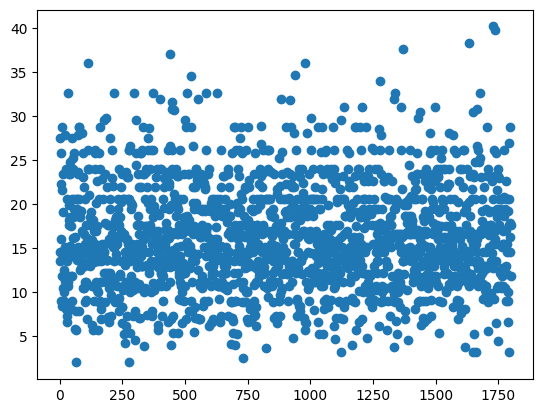

In [ ]:
#standard deviation of data
df_describe = pd.DataFrame(runup_all[0])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

,0
count,1800.000000
mean,11.152342
std,4.552236
min,0.572627
25%,8.079904
50%,10.652256
75%,13.244613
max,32.744892


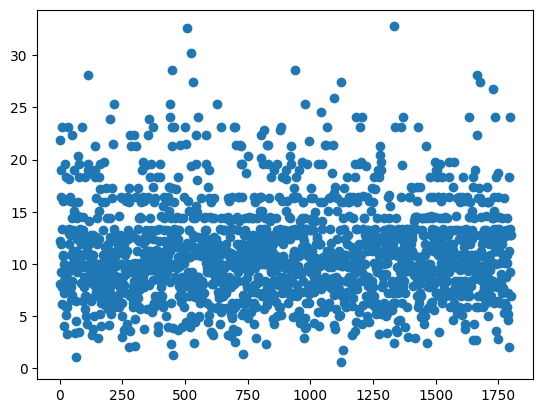

In [ ]:
#standard deviation of data
df_describe = pd.DataFrame(runup_all[1])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

,0
count,1800.000000
mean,5.827220
std,1.778166
min,1.096356
25%,4.581965
50%,5.859406
75%,7.014544
max,16.075523


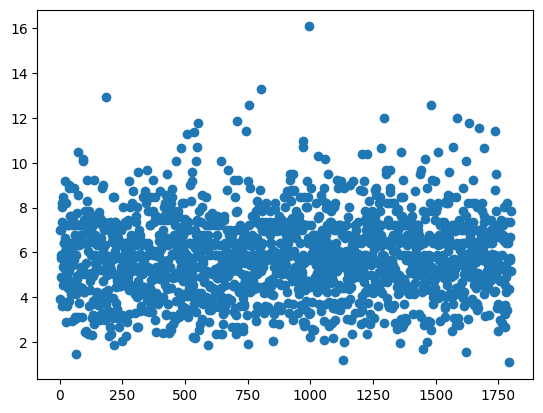

In [ ]:
#standard deviation of data
df_describe = pd.DataFrame(runup_all[3])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

,0
count,1800.000000
mean,26258.797222
std,12091.684186
min,1104.000000
25%,16263.000000
50%,24839.000000
75%,36581.500000
max,58798.000000


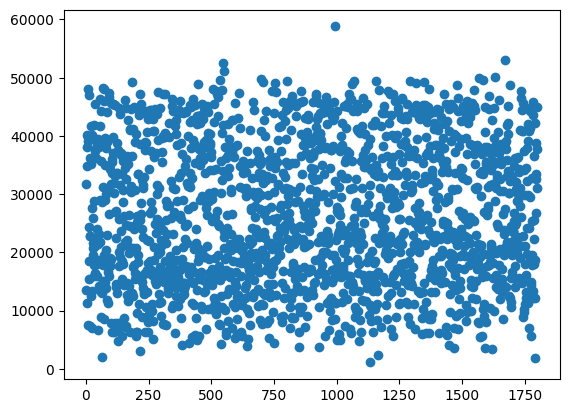

In [ ]:
#standard deviation of data
df_describe = pd.DataFrame(inund_px_all[3])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

In [ ]:
# adding trainable network

# trainable network body

trainable_net = Sequential([
  Conv2D(16, (2, 2), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu',  kernel_regularizer=regularizers.l2(L2)),
], name='trainable_net')(net_input)

# trainable network output

trainable_output = Dense(12,'linear', name='trainable_out')(trainable_net)

# using a lambda layer so we can control the weight (beta) of the prior network

prior_scale = Lambda(lambda x: x * 30, name='prior_scale')(prior_output) #beta=30 = sd*5 = 12091*5

# lastly, we use a add layer to add both networks together and get Q

add_output = add([trainable_output, prior_scale], name='add')

# defining the model
model = Model(inputs=net_input, outputs=add_output)

trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 150, 132, 1)]        0         []                            
                                                                                                  
 prior_net (Sequential)      (None, 64)                   804272    ['input[0][0]']               
                                                                                                  
 trainable_net (Sequential)  (None, 64)                   804272    ['input[0][0]']               
                                                                                                  
 prior_out (Dense)           (None, 12)                   780       ['prior_net[0][0]']           
                                                                                            

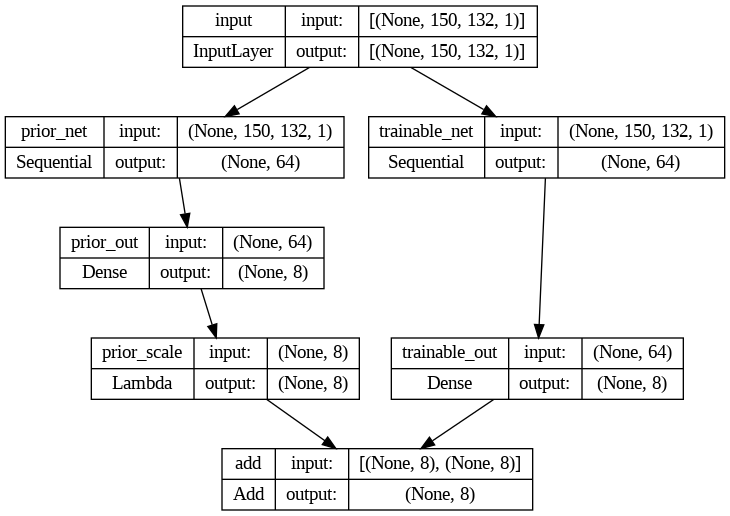

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### N° NNs in the ensemble

In [ ]:
import time

#N° NNs:
#10,20,30,50,100,200

nsims=200

y_star_train= np.zeros([1440,12,nsims])
y_star_test = np.zeros([360,12,nsims])
times= np.zeros(nsims)


for i in range(nsims):
  start = time.time()

  model = Model(inputs=net_input, outputs=add_output)
  trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,validation_data=(test_images, test_labels))

  times[i]=time.time()-start
  y_star_test[:,:,i] = model.predict(test_images)
  y_star_train[:,:,i] = model.predict(train_images)

Streaming output truncated to the last 5000 lines.
45/45 [==============================] - 0s 8ms/step - loss: 0.0630 - mean_squared_error: 0.0104 - val_loss: 0.4165 - val_mean_squared_error: 0.3639
Epoch 115/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0610 - mean_squared_error: 0.0084 - val_loss: 0.4173 - val_mean_squared_error: 0.3647
Epoch 116/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0601 - mean_squared_error: 0.0075 - val_loss: 0.4157 - val_mean_squared_error: 0.3632
Epoch 117/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0578 - mean_squared_error: 0.0053 - val_loss: 0.4115 - val_mean_squared_error: 0.3590
Epoch 118/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0574 - mean_squared_error: 0.0049 - val_loss: 0.4139 - val_mean_squared_error: 0.3614
Epoch 119/200
45/45 [==============================] - 0s 8ms/step - loss: 0.0565 - mean_squared_error: 0.0041 - val_loss: 0.4139 - val_mean_squared

In [ ]:
#Save variables in .npy
np.save('../content/drive/MyDrive/Data/test_uplift_data1_bayesian_200_12.npy',y_star_test)
np.save('../content/drive/MyDrive/Data/train_uplift_data1_bayesian_200_12.npy',y_star_train)
np.save('../content/drive/MyDrive/Data/times_uplift_data1_bayesian_200_12.npy',times)

In [ ]:
#Load variables
y_star_test=np.load('../content/drive/MyDrive/Data/test_uplift_data1_bayesian_200_12.npy')
y_star_train=np.load('../content/drive/MyDrive/Data/train_uplift_data1_bayesian_200_12.npy')
times=np.load('../content/drive/MyDrive/Data/times_uplift_data1_bayesian_200_12.npy')
print(y_star_test.shape)
print(y_star_train.shape)
print(times.shape)

(360, 12, 200)
(1440, 12, 200)
(200,)


In [ ]:
#Residuals Calculation
nsims=200
residuales_test= np.zeros([360,12,nsims])
residuales_train= np.zeros([1440,12,nsims])

sumt=np.zeros(nsims)

for i in range(nsims):
  sumt[i]=sum(times[0:(i+1)])
  residuales_test[:,:,i]=y_star_test[:,:,i]-test_labels[:,:]
  residuales_train[:,:,i]=y_star_train[:,:,i]-train_labels[:,:]


print(residuales_train.shape)
print(residuales_test.shape)

(1440, 12, 200)
(360, 12, 200)


In [ ]:
#MSE and time calculation for 200 NNs
mse_test=np.zeros(nsims)
aux_test=np.zeros(nsims)

mse_train=np.zeros(nsims)
aux_train=np.zeros(nsims)

aux1=0
aux2=0
aux3=0

for i in range(nsims):
  #Train
  aux1=np.reshape(residuales_train[:,:,i],(-1,1))[:,0]
  aux_train[i]=np.dot(aux1,aux1)
  aux2=aux_train[i]+aux2
  mse_train[i]=aux2/(1440*12*(i+1)) #1440*8 or len(aux1)

  #Test
  aux1=np.reshape(residuales_test[:,:,i],(-1,1))[:,0]
  aux_test[i]=np.dot(aux1,aux1)
  aux3=aux_test[i]+aux3
  mse_test[i]=aux3/(360*12*(i+1))  #360*8 or len(aux1)

#MSE
mse_train10= mse_train[9]
mse_train20= mse_train[19]
mse_train30= mse_train[29]
mse_train50= mse_train[49]
mse_train100= mse_train[99]
mse_train200= mse_train[199]
mse = np.array((mse_train10, mse_train20, mse_train30, mse_train50, mse_train100, mse_train200))


#time
time10= sum(times[0:9])/60
time20= sum(times[0:19])/60
time30= sum(times[0:29])/60
time50= sum(times[0:49])/60
time100= sum(times[0:99])/60
time200= sum(times[0:199])/60
time = np.array((time10, time20, time30, time50, time100, time200))
#time = np.array((time10, time20, time30, time50, time100))

NNs = np.array((10,20,30,50,100,200))

In [ ]:
#SD and mean residual calculation
sigmas_test= np.zeros((12,nsims))
mus_test= np.zeros((12,nsims))

sigmas_train= np.zeros((12,nsims))
mus_train= np.zeros((12,nsims))


aux_test=residuales_test[:,:,0]
sigmas_test[:,0]=np.std(residuales_test[:,:,0],axis=0)
mus_test[:,0]=np.mean(residuales_test[:,:,0],axis=0)

aux_train=residuales_test[:,:,0]
sigmas_train[:,0]=np.std(residuales_test[:,:,0],axis=0)
mus_train[:,0]=np.mean(residuales_test[:,:,0],axis=0)


for i in range(nsims):
  if i==0:
    i=1

  aux_test=np.append(aux_test,residuales_test[:,:,i],axis=0)
  sigmas_test[:,i]=np.std(aux_test,axis=0)
  mus_test[:,i]=np.mean(aux_test,axis=0)

  aux_train=np.append(aux_train,residuales_train[:,:,i],axis=0)
  sigmas_train[:,i]=np.std(aux_train,axis=0)
  mus_train[:,i]=np.mean(aux_train,axis=0)


## Graphics to summarize the results for the election of the N° NNs

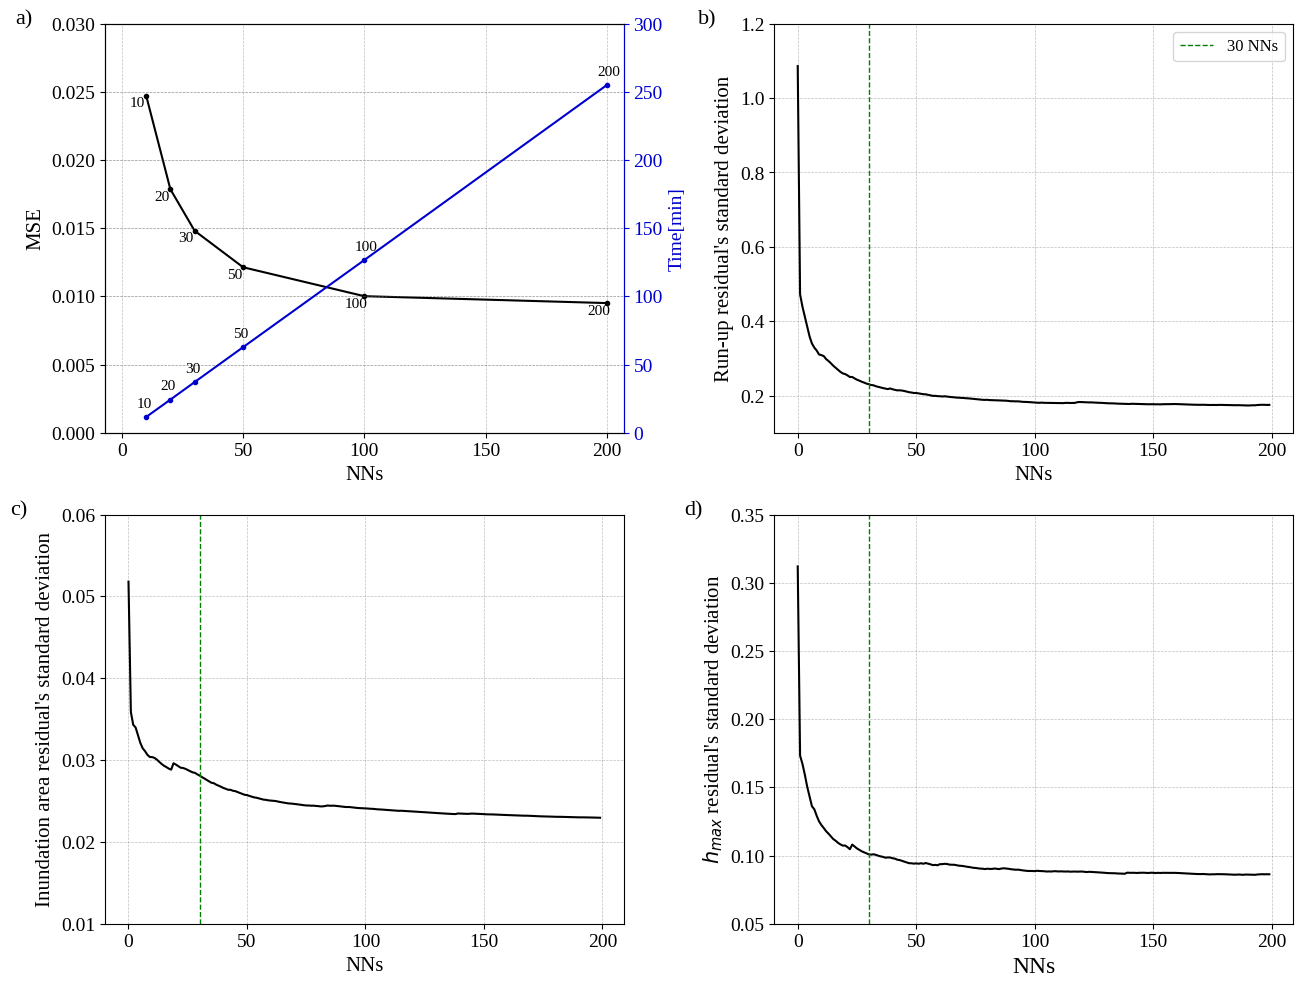

In [ ]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

#Fonth Liberation Serif
font_path = fm.findSystemFonts(fontpaths=None, fontext='ttf')
liberation_serif_fonts = [font for font in font_path if 'liberationserif' in font.lower()]

liberation_serif_font = liberation_serif_fonts[0] if liberation_serif_fonts else None

if liberation_serif_font:
    plt.rcParams['font.family'] = "Liberation Serif"


fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, figure=fig)
NNs = np.array((10,20,30,50,100,200))

#Plot 1
ax1 = fig.add_subplot(gs[0, 0:1])
ax1.plot(NNs, mse,label='Train', marker= '.', color= 'k')
ax1.set_xlabel('NNs', color='k', size=15)
ax1.set_ylabel('MSE', color='k', size=15)
ax1.set_xlim([-7,207])
ax1.set_ylim([0.00,0.030])
ax1.tick_params(axis='x', color='k', labelcolor='k', labelsize=14)
ax1.tick_params(axis='y', color='k', labelcolor='k', labelsize=14)

for i, nn in enumerate(NNs):
    ax1.annotate(f'{nn}', (NNs[i], mse[i]), textcoords="offset points", xytext=(-6, -8), ha='center', fontsize=11, color='k')

plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax2 = ax1.twinx()
ax2.plot(NNs, time,'mediumblue', marker= '.')
ax2.set_ylabel('Time[min]', color='mediumblue', size=14)
ax2.set_ylim([0,300])
ax2.tick_params(axis='y', color='mediumblue', labelcolor='mediumblue', labelsize=14)
ax2.spines['right'].set_color('mediumblue')
ax2.spines['left'].set_color('k')
plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax1.text (-44,0.030, "a)", fontsize= 16)

for i, nn in enumerate(NNs):
    ax2.annotate(f'{nn}', (NNs[i], time[i]), textcoords="offset points", xytext=(-7, 7), ha='left', fontsize=11, color='k')

#Plot 2
ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(sigmas_train[0,:], 'k')
ax3.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax3.set_xlabel('NNs', color='k', size=15)
ax3.set_ylabel('Run-up residual\'s standard deviation', color='k', size=15)
ax3.set_ylim([0.1,1.2])
ax3.tick_params(axis='y', color='k', labelcolor='k', labelsize=14)
ax3.tick_params(axis='x', color='k', labelcolor='k', labelsize=14)
ax3.text (-42,1.2, "b)", fontsize= 16)
ax3.axvline(x=30, color='g', linestyle='--', linewidth=1, label='30 NNs')
ax3.legend(loc='upper right', fontsize=12)

#plot 3
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sigmas_train[4,:], 'k')
ax4.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax4.set_xlabel('NNs', color='k', size=15)
ax4.set_ylabel('Inundation area residual\'s standard deviation', color='k', size=15, fontname="Liberation Serif")
ax4.set_ylim([0.01,0.06])
ax4.tick_params(axis='y', color='k', labelcolor='k', labelsize=14)
ax4.tick_params(axis='x', color='k', labelcolor='k', labelsize=14)
ax4.text (-50,0.06, "c)", fontsize= 16)
ax4.axvline(x=30, color='g', linestyle='--', linewidth=1)

#plot 4
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sigmas_train[8,:], 'k')
ax5.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax5.set_xlabel('NNs', color='k', size=17)
ax5.set_ylabel('$h_{max}$ residual\'s standard deviation', color='k', size=15, fontname="Liberation Serif")
ax5.set_ylim([0.05,0.35])
ax5.tick_params(axis='y', color='k', labelcolor='k', labelsize=14)
ax5.tick_params(axis='x', color='k', labelcolor='k', labelsize=14)
ax5.text (-48,0.35, "d)", fontsize= 16)
ax5.axvline(x=30, color='g', linestyle='--', linewidth=1)

plt.savefig('/content/drive/MyDrive/Data/Figure6.pdf', bbox_inches='tight', dpi=800)
plt.subplots_adjust(left=0.0, right=0.99, top=0.95, bottom=0.05, wspace=0.29)  # Ajusta wspace y otros márgenes
plt.show()



### Residuals and SD for 30 NNs

In [ ]:
#Predictions
predict = y_star_test[:,:,0:30]

#Run-up
means=np.mean(predict[:,0,:], axis=1)
stddev=np.std(predict[:,0,:],axis=1,ddof=1)
x = test_labels[:,0]
y= means
residual = y-x #mean predictions-predictions
mu, std = stats.norm.fit(residual)

In [ ]:
#Inundation area
means4=np.mean(predict[:,4,:]*68771*1e-6, axis=1)
stddev4=np.std(predict[:,4,:]*68771*1e-6,axis=1,ddof=1)
x4 = test_labels[:,4]*68771*1e-6
y4= means4
residual4 = y4-x4 #mean predictions-predictions
mu4, std4 = stats.norm.fit(residual4)

In [ ]:
#hmax
means8=np.mean(predict[:,8,:], axis=1)
stddev8=np.std(predict[:,8,:],axis=1,ddof=1)
x8 = test_labels[:,8]
y8= means8
residual8 = y8-x8 #mean predictions-predictions
mu8, std8 = stats.norm.fit(residual8)

-2.0190306790213755
2.1343970592802184
-0.004800854984661193
0.004497462392591524


<ipython-input-43-14a1dba9d643>:129: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(mapper)


-0.5908858379495358
0.5884742863693225


<ipython-input-43-14a1dba9d643>:201: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(mapper)


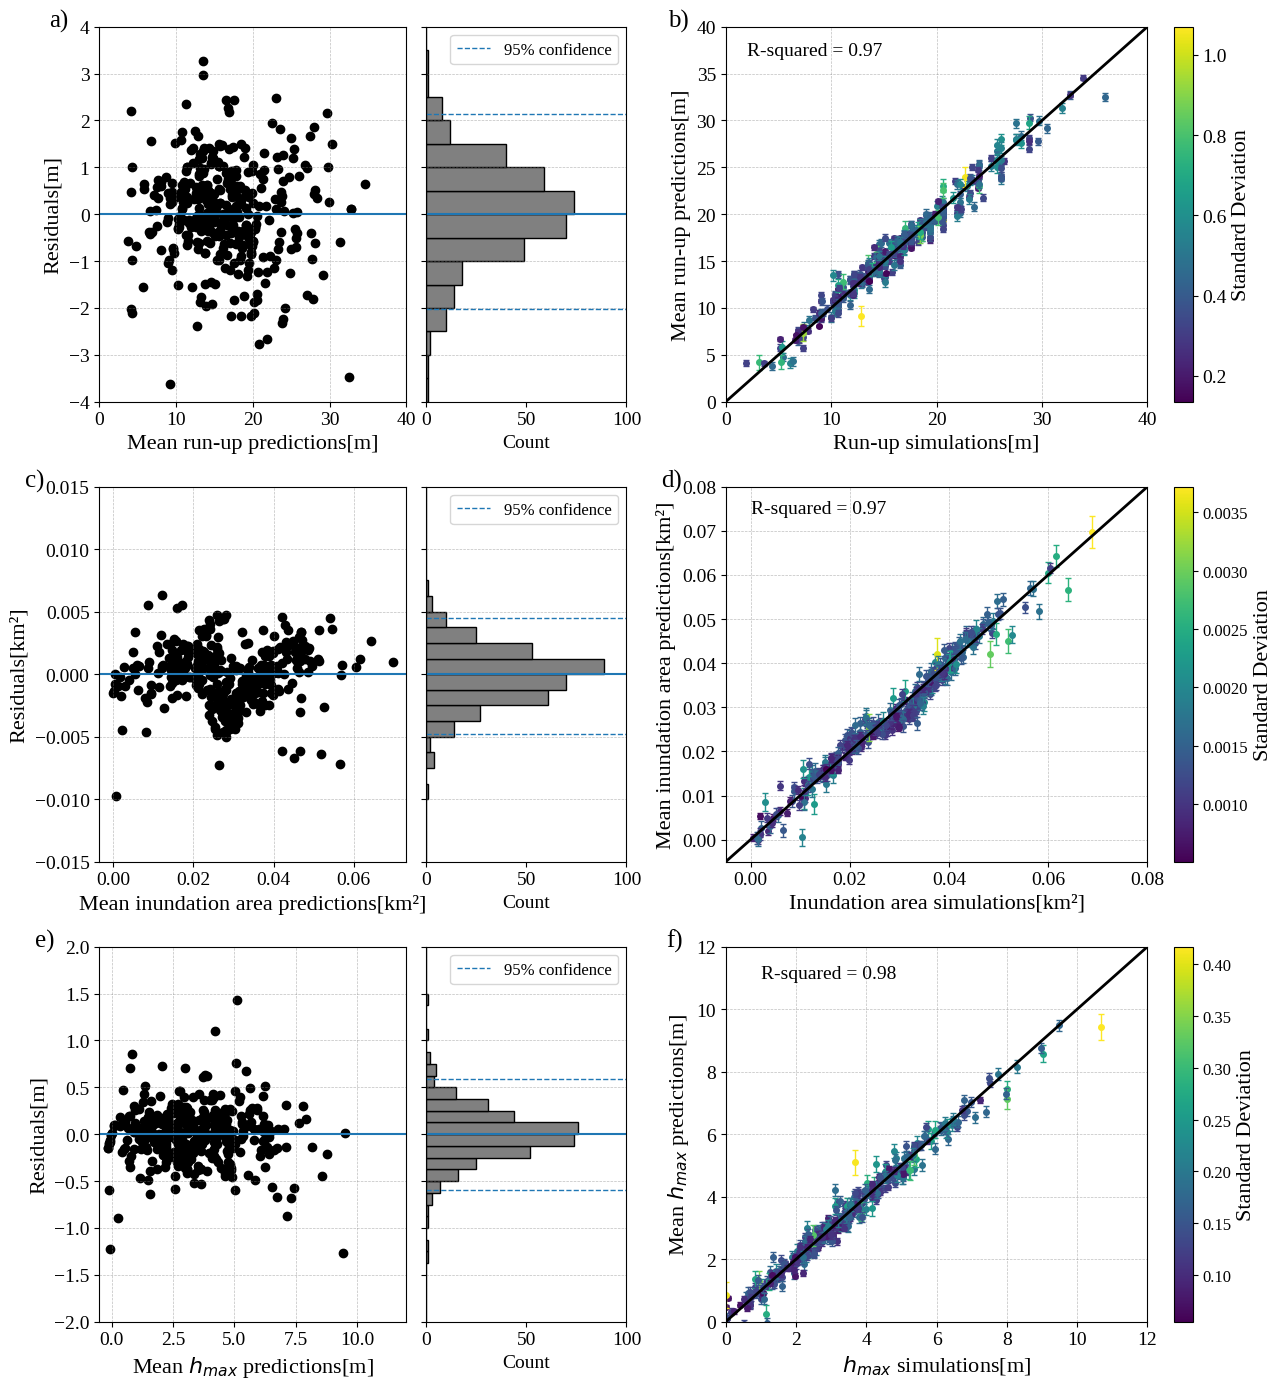

In [ ]:
#Uncertainty plots
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors


fig = plt.figure(figsize=(13, 14))
gs = GridSpec(3, 2, figure=fig)

#Plot 1
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y, residual, color='k')
ax1.set_xlabel('Mean run-up predictions[m]', fontsize=16)
ax1.set_ylabel('Residuals[m]', fontsize=16)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.axhline(y=0, linewidth=1.5)
ax1.set_xlim([0, 40])
ax1.set_ylim([-4, 4])
ax1.text(-6.5,4.0, "a)", fontsize= 18)

#Histogram
divider = make_axes_locatable(ax1)
ax_histy = divider.append_axes("right", 2, pad=0.2, sharey=ax1)
ax_histy.yaxis.set_tick_params(labelleft=False)
w = 0.5
ax_histy.hist(residual, bins=np.arange(-4, 4 + w, w), edgecolor='black', orientation='horizontal', color='gray')
ax_histy.set_xlabel('Count', fontsize=14)
ax_histy.tick_params(axis="x", labelsize=14)
ax_histy.set_xlim([0, 100])
ax_histy.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
ax_histy.axhline(y=0, linewidth=1.5)
conf = mu - 2 * std
conf_ = mu + 2 * std
ax_histy.axhline(y=conf, linestyle='--', linewidth=1, label="95% confidence")
ax_histy.axhline(y=conf_, linestyle='--', linewidth=1)
ax_histy.legend(loc='best', fontsize="large")


#Plot 2
ax2 = fig.add_subplot(gs[0, 1])
yerr = stddev
sc=plt.scatter(x,y, s=0.1, c=yerr)
norm = matplotlib.colors.Normalize(vmin=min(yerr), vmax=max(yerr), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
time_color = np.array([(mapper.to_rgba(v)) for v in yerr])

cb = plt.colorbar(mapper, ax=ax2)
cb.set_label("Standard Deviation", fontsize=16)
cb.ax.tick_params(labelsize=14)

for X, Y, e, color in zip(x, y, yerr, time_color):
  ax2.plot(X, Y, 'o', color=color, markersize=4)
  ax2.errorbar(X, Y, e, lw=1, capsize=2, color=color)

ax2.text(-5.5, 40, "b)", fontsize=18)
ax2.set_xlabel('Run-up simulations[m]', fontsize=16)
ax2.set_ylabel('Mean run-up predictions[m]', fontsize=16)
ax2.axline([0, 0], [1, 1], color="k", linewidth=2)
ax2.text(2, 37, 'R-squared = %0.2f' % r2, fontsize=14)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlim([0, 40])
ax2.set_ylim([0, 40])
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

#Plot 3
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y4, residual4, color='k')
ax3.set_xlabel('Mean inundation area predictions[km²]',fontsize = 16)
ax3.set_ylabel('Residuals[km²]',fontsize = 16)
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)
ax3.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax3.axhline(y=0, linewidth=1.5)
ax3.set_ylim([-0.015, 0.015])
ax3.text (-0.022,0.015, "c)", fontsize= 18)

#Histogram
divider = make_axes_locatable(ax3)
ax_histy = divider.append_axes("right",2, pad=0.2, sharey=ax3)
ax_histy.yaxis.set_tick_params(labelleft=False)
w=.00125
ax_histy.hist(residual4, bins=np.arange(-0.015, 0.015 + w, w), edgecolor = 'black',orientation='horizontal', color='gray')
ax_histy.set_xlabel('Count',fontsize = 14)
ax_histy.tick_params(axis="x", labelsize=14)
ax_histy.set_xlim([0, 100])
ax_histy.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
ax_histy.axhline(y=0, linewidth=1.5)
conf = mu4 - 2 * std4
conf_ = mu4 + 2 * std4
ax_histy.axhline(y=conf, linestyle='--', linewidth=1, label="95% confidence")
ax_histy.axhline(y=conf_, linestyle='--', linewidth=1)
ax_histy.legend(loc='best', fontsize="large")

#plot 4
ax4 = fig.add_subplot(gs[1, 1])
x4 = test_labels[:,4]*68771*1e-6
y4= means4
yerr4 = stddev4
sc=plt.scatter(x4,y4, s=0.1, c=yerr4)
norm = matplotlib.colors.Normalize(vmin=min(yerr4), vmax=max(yerr4), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
time_color = np.array([(mapper.to_rgba(v)) for v in yerr4])
cb=plt.colorbar(mapper)
cb.set_label("Standard Deviation", fontsize = 16)
cb.ax.tick_params(labelsize=12)

for X, Y, e, color in zip(x4, y4, yerr4, time_color):
    ax4.plot(X, Y, 'o', color=color,markersize=4)
    ax4.errorbar(X, Y, e, lw=1, capsize=2, color=color)

ax4.text (-.018,0.08, "d)", fontsize= 18)
ax4.set_xlabel('Inundation area simulations[km²]',fontsize = 16)
ax4.set_ylabel('Mean inundation area predictions[km²]',fontsize = 16 )
ax4.axline([0,0], [1,1], color="k", linewidth=2)
ax4.text(0, 0.074, 'R-squared = %0.2f' % r2_4, fontsize= 14)
ax4.tick_params(axis="x", labelsize=14)
ax4.tick_params(axis="y", labelsize=14)
ax4.set_xlim([-0.005, 0.08])
ax4.set_ylim([-0.0050, 0.08])
ax4.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)


#PLOT  5
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(y8, residual8, color='k')
ax5.set_xlabel('Mean $h_{max}$ predictions[m]',fontsize = 16)
ax5.set_ylabel('Residuals[m]',fontsize = 16)
ax5.tick_params(axis="x", labelsize=14)
ax5.tick_params(axis="y", labelsize=14)
ax5.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax5.axhline(y=0, linewidth=1.5)
ax5.set_xlim([-0.5, 12])
ax5.set_ylim([-2, 2])
ax5.text (-3.1,2, "e)", fontsize= 18)

#Histogram
divider = make_axes_locatable(ax5)
ax_histy = divider.append_axes("right",2, pad=0.2, sharey=ax5)
ax_histy.yaxis.set_tick_params(labelleft=False)
w=.125
ax_histy.hist(residual8, bins=np.arange(-2, 2 + w, w), edgecolor = 'black',orientation='horizontal', color='gray')
ax_histy.set_xlabel('Count',fontsize = 14)
ax_histy.tick_params(axis="x", labelsize=14)
ax_histy.set_xlim([0, 100])
ax_histy.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
ax_histy.axhline(y=0, linewidth=1.5)
conf = mu8 - 2 * std8
conf_ = mu8 + 2 * std8
ax_histy.axhline(y=conf, linestyle='--', linewidth=1, label="95% confidence")
ax_histy.axhline(y=conf_, linestyle='--', linewidth=1)
ax_histy.legend(loc='best', fontsize="large")

#plot 6
ax6 = fig.add_subplot(gs[2, 1])
x8 = test_labels[:,8]
y8= means8
yerr8 = stddev8
sc=plt.scatter(x8,y8, s=0.1, c=yerr8)

norm = matplotlib.colors.Normalize(vmin=min(yerr8), vmax=max(yerr8), clip=True)

mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
time_color = np.array([(mapper.to_rgba(v)) for v in yerr8])
cb=plt.colorbar(mapper)
cb.set_label("Standard Deviation", fontsize = 16)
cb.ax.tick_params(labelsize=12)

for X, Y, e, color in zip(x8, y8, yerr8, time_color):
    ax6.plot(X, Y, 'o', color=color,markersize=4)
    ax6.errorbar(X, Y, e, lw=1, capsize=2, color=color)

ax6.text (-1.7,12, "f)", fontsize= 18)
ax6.set_xlabel('$h_{max}$ simulations[m]',fontsize = 16)
ax6.set_ylabel('Mean $h_{max}$ predictions[m]',fontsize = 16 )
ax6.axline([0,0], [1,1], color="k", linewidth=2)
ax6.text(1, 11, 'R-squared = %0.2f' % r2_8, fontsize= 14)
ax6.tick_params(axis="x", labelsize=14)
ax6.tick_params(axis="y", labelsize=14)
ax6.set_xlim([-0, 12])
ax6.set_ylim([-0, 12])
ax6.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)


plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Data/Figure8.pdf', bbox_inches='tight', dpi=800)
plt.show()